# **Mario**
### This project aims to implement a Deep Q-Network on SNES Mario, meaning, training a Deep Q-Learning Reinforcement Mario Agent to beat the entirity of Super Mario Bros using a Convolutional Neural Network.

**Eve Collier\
AI II - Spring 2025\
Final Project**

![Mario](https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExdmFvcTg0dDBnbnQ1b3BjbzlnemJnbGVrdm02a29pbDF4a3ExcGF2eiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/DqqHabAaTHRII/giphy.gif)

First, we need to install the game and import some stuff:

In [9]:
!pip install gym_super_mario_bros==7.3.0 nes_py torch opencv-python
import gym
import gym_super_mario_bros
import numpy as np
import torch
import torch.nn as nn
import cv2
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from collections import deque
from gym import Wrapper
import os
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import clear_output


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [10]:
!pip install gym_super_mario_bros==7.3.0 nes_py
import gym_super_mario_bros
import nes_py
from nes_py.wrappers import JoypadSpace # Wrap the game 
from gym_super_mario_bros.actions import RIGHT_ONLY # Simplify what a Mario agent can do, 256 actions it can do otherwise


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


Cool.
Now, wrappers. We have three custom wrappers defined below- SkipFrame, GrayScaleObservation, and FrameStack. I will explain GrayScale first, because SkipFrame and FrameStack go hand-in-hand.
### GrayScaleObservation:
- SNES Mario ROM is in RGB format. That is 3 channels, which makes things more complex and take longer. Most tutorials interfacing with the gym libraries resizes the interfaced game down to one channel, plus I already don't have a GPU, so I decided to take this approach.
- This wrapper exists to resize the game down into one channel- a black and white version with sketches that show whats happening without all of the extra fancy stuff. This makes things a whole lot less complex.

### SkipFrame & FrameStack:
- These exist to help speed up training. Instead of having Mario act for every frame, I have him act once per four frames- so there is less computations and things happening- the agent will not choose an action for every single frame of the game. That would be a crazy number of computations- there's already a crazy number of computations happening.
- SkipFrame repeats an action taken by Mario for four frames, and FrameStack stacks the last 4 frames on top of eachother. Framestack is needed because one singular frame will not show motion- for example, a jump- so stacking the 4 frames allows for the agent a window to see movement. This is IMPORTANT- without it, Mario wouldn't be able to time jumps well enough to get over pits and enemies. He also wouldn't be able to see what direction enemies are moving in.
- We use FrameStack to compensate for SkipFrame- when an action is repeated for 4 frames, the agent only sees every 4th frame. The agent won't be able to see what happened in those previous three frames- so if Mario jumps, the agent might miss the start of the jump or the moment he hits the ground.
- By stacking the last 4 observed frames in FrameStack, the agent is given enough information to infer motion- is the enemy getting closer or farther? Am I jumping or falling? Am I walking into a pipe right now?
- We have FrameStack because SkipFrame would blind the agent to what's happening between frames.


In [11]:
# Custom Wrappers

# SkipFrame
# Skips a set number of frames by repeating the same action.
# Reduces the # of decisions the agent needs to make.
# Parameters:
# Wrapper - the Gym class SkipFrame is inheriting from
# Returns last observation w/ its accumulated reward
class SkipFrame(Wrapper):
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._skip = skip # Num of frames to skip
        
    # step returns...
    # obs: the observation from the last repeated step
    # total_reward: sum of rewards from skipped frames
    # done: true or false based off if the episode has ended
    # info: Mario's position, coins, etc.
    def step(self, action):
        total_reward = 0.0
        done = False
        for _ in range(self._skip):
            # Repeat the action for 'skip' frames
            step_result = self.env.step(action)
            # Handle both old and new Gym API formats:
            if len(step_result) == 4:  # Old API
                obs, reward, done, info = step_result
                terminated, truncated = done, False
            else:  # New API
                obs, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            
            total_reward += reward # Accumulate rewards over skipped frames
            if done:
                break # Stop skipping if episode ends suddenly (Mario dies)
        return obs, total_reward, done, info

    def reset(self):
        return self.env.reset() # returns ONE observation

# GrayScaleObservation
# Converts RGB frames to grayscale and resizes them to 84x84.
# Parameters:
# Wrapper - the Gym class GrayScaleObservation is inheriting from
# Returns a grayscale image as a numpy.ndarray
class GrayScaleObservation(Wrapper):
    def __init__(self, env):
        super().__init__(env)
        # Define observation space for grayscale (single channel, 84x84)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84), dtype=np.uint8)

    def observation(self, obs):
        if isinstance(obs, tuple):  # Newer Gym sometimes returns (obs, info)
            obs = obs[0]
        # Convert RGB to grayscale
        obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        # Resize to 84x84 for consistency with DQN input
        obs = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_AREA)
        return obs
        
    # step returns...
    # grayscale_obs: a single-channel (grayscale) image
    # reward: the reward for the action 
    # done: true or false based off if the episode has ended
    # info: Mario's position, coins, etc.
    def step(self, action):
        step_result = self.env.step(action)
        # Handle both old and new Gym API formats
        if len(step_result) == 4:  # Old API
            obs, reward, done, info = step_result
        else:  # New API
            obs, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        return self.observation(obs), reward, done, info

    def reset(self):
        obs = self.env.reset()
        return self.observation(obs)

# FrameStack
# Stacks multiple consecutive frames together to give the agent a sense of motion.
# Parameters:
# Wrapper - the Gym class FrameStack is inheriting from
# Returns NumPy array of shape (num_stack, 84, 84)- to stack the agent's first observation num_stack times
class FrameStack(Wrapper):
    def __init__(self, env, num_stack=4):
        super().__init__(env)
        self.num_stack = num_stack            # Number of frames to stack
        self.frames = deque(maxlen=num_stack) # Store the latest 'num_stack' frames
        
        # Define observation space for stacked grayscale frames
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(num_stack, 84, 84), dtype=np.uint8)

    def reset(self):
        obs = self.env.reset()
        # Fill the deque with the same frame initially
        for _ in range(self.num_stack):
            self.frames.append(obs)
        return np.stack(self.frames) # Return stacked frames as one observation
        
    # step returns...
    # stacked_obs: a stack of the most recent num_stack frames 
    # reward: the reward for the action 
    # done: true or false based off if the episode has ended
    # info: Mario's position, coins, etc.
    def step(self, action):
        step_result = self.env.step(action)
        # Handle both old and new Gym API formats
        if len(step_result) == 4:  # Old API
            obs, reward, done, info = step_result
        else:  # New API
            obs, reward, terminated, truncated, info = step_result
            done = terminated or truncated
        self.frames.append(obs) # Add new frame to the stack
        return np.stack(self.frames), reward, done, info

Now we can define our Neural Net. I decided to model my Neural Network after- https://github.com/adhiiisetiawan/atari-dqn/blob/main/dqn_atari.py 
This is the original DQN architecture that played Atari games. CNN layers extract spatial and motion features- like the movement of goombas/koopas. The fully connected layers reason over the features to choose the best action. So, in short, my neural network is a convolutional neural network that uses convolutional layers to process image data and extract spatial features. My Mario agent uses the CNN to approximate the Q-function and learn to predict the expected return for each action in a given state. **The Mario agent is a Q-Learning agent that uses a CNN to process image input.** 


Input: A 4D tensor of shape (batch_size, 4, 84, 84) (basically, batches of 4 stacked grayscale frames).\
Output: A 2D tensor of shape (batch_size, n_actions), where each value is a Q-value corresponding to a possible action Mario can take.

In [12]:
# MarioNet
# Definition of the Convolutional Neural Network for Deep Q-Learning
# Returns the predicted values of each action in the state 
class MarioNet(nn.Module):
    # Parameters:
    # input_shape - a tuple that represents the shape of the input image from the Mario environment
    # n_actions   - the # of possible actions Mario can take (AKA output size of the network), we have one value per action.
    def __init__(self, input_shape, n_actions):
        super().__init__()
        # input_shape: tuple (channel, height, width)
        c, h, w = input_shape
        # Sequential CNN block to get features of env from visual input. Inspired by: https://medium.com/@liyinxuan0213/step-by-step-double-deep-q-networks-double-dqn-tutorial-from-atari-games-to-bioengineering-dec7e6373896 and https://github.com/adhiiisetiawan/atari-dqn/blob/main/dqn_atari.py 
        self.net = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=8, stride=4), nn.ReLU(),  # Input conv layer: input channels (c), 32 output filters, 8x8 kernel, stride 4
            nn.Conv2d(32, 64, kernel_size=4, stride=2), nn.ReLU(), # Conv layer: 32 in, 64 out, 4x4 kernel, stride 2
            nn.Conv2d(64, 64, kernel_size=3, stride=1), nn.ReLU(), # Conv layer: 64 in, 64 out, 3x3 kernel, stride 1
            nn.Flatten(),  # Flatten feature maps to feed into fully connected layers
            nn.Linear(7 * 7 * 64, 512), nn.ReLU(), # Fully connected layer: 7x7x64 = 3136 input features -> 512
            nn.Linear(512, n_actions)              # Output layer: 512 -> number of possible actions
        )
    # Forward pass through the network
    # Returns a tensor- each row contains the Q-values for each action in said state.
    def forward(self, x):
        return self.net(x)

I chose this approach because mostly every tutorial I found online regarding AI and Atari games did this. https://medium.com/@liyinxuan0213/step-by-step-double-deep-q-networks-double-dqn-tutorial-from-atari-games-to-bioengineering-dec7e6373896 is the resource that really helped me understand the approach. Mostly because of this image from said resource: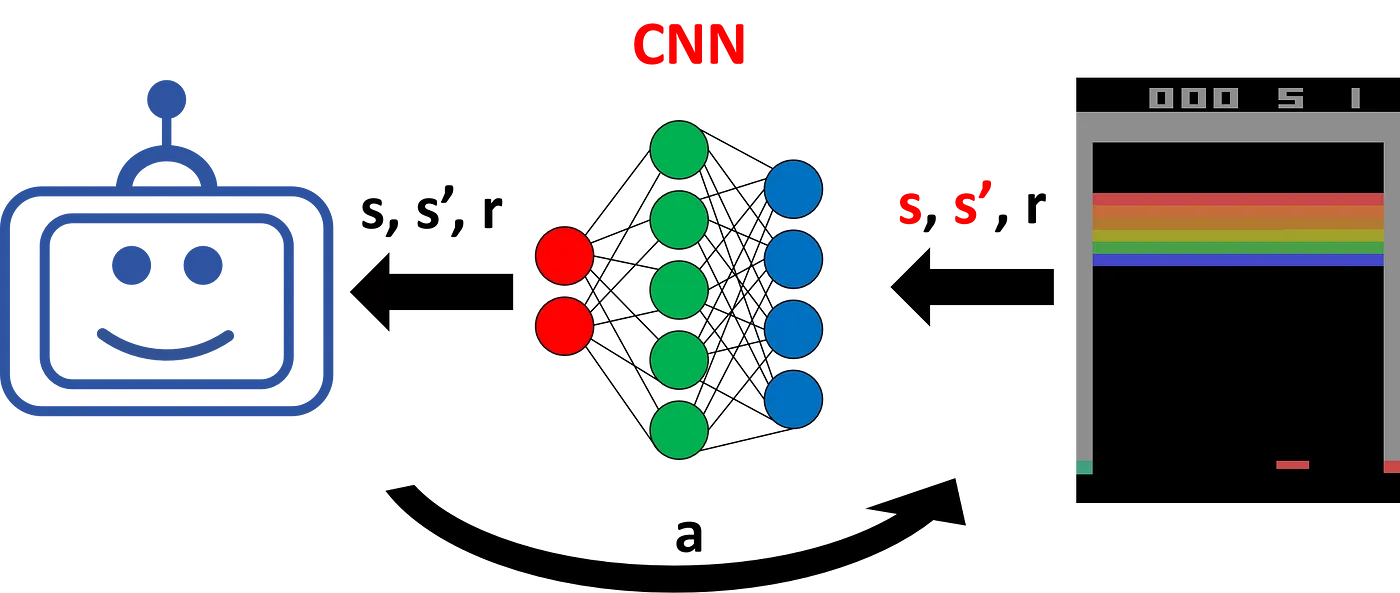

The CNN extracts features from the enviroment, which in turn can be used to generalize features across states similar to the one the agent is on. The DQN appraoch allows our Mario Agent to choose actions based on inferences made based off of extracted features of the enviroment. Boom.

Now for our Mario agent. 
## Mario Agent
- The Mario class is a Deep Q-Learning Reinforcement Agent that exists to play Super Mario Bros. It combines deep learning, difference learning, and heuristics to do this.
- We technically use two CNNs because one wasn't confusing enough. I'm kidding. net handles the current Q-value predictions by updating its weights frequently and learns Q-values through backpropagation. target_net is used for target value inferencing- we calculate stable training targets by NOT updating weights every step like net- instead we sync periodically. Basically, they work together to predict expected furture rewards for each action within the current game state- using the stable target_net gives the Q-learning a goal to aim toward.
- We have a replay buffer- memory- that stores Mario's past experiences- this allows for the agent to learn from randomly sampled data that is not correlated.
- We balance exploration and exploitation by having the agent switch between exploring (random actions) and choosing an action based on learned Q-values.
- Vision based heuristics (detect_pit and detect_enemy) should help the Mario agent make decisions by reacting to dangers. I say should because they don't.
- Tracks past death positions (death_positions) and does the highest/longest jump when near those locations to avoid repeating fatalty-inducing  mistakes.
- Training happens after this class definition and repeatedly calls act(), cache(), and learn() - those methods play huge parts in training...
- act() chooses an action based on exploration or exploitation
- cache() stores the experience in memory so the Mario agent can learn from it later
- learn() samples from stored experiences in Mario's memory and updates the model parameters to minimize the difference between predicted and target Q-values for a single step taken by Mario. Backpropagation and gradients are dealt with in this helper function.

In [13]:
# Mario Agent Definition:
class Mario:
    # Initialize the agent's neural network, memory, training logic, and exploration strategy.
    # Parameters:
    # state_shape: the shape of the input state as a tuple
    # num_actions: the number of actions Mario can take
    def __init__(self, state_shape, num_actions):
        # Shape of input state and number of actions
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Predict Q-values for each action given a state
        self.net = MarioNet(state_shape, num_actions).to(self.device) # MAIN DQN network predicts Q-Values from state
        self.jump_cooldown = 0
        self.last_status = 'small'
        self.last_x_pos = 0
        self.stuck_counter = 0
        # Target Q-network: used for training targets
        self.target_net = MarioNet(state_shape, num_actions).to(self.device) # Seperate target network used to compute training targets 
        self.target_net.load_state_dict(self.net.state_dict())  # Sync initially
        self.target_net.eval() # No gradient tracking needed
        self.death_positions = [] # Track x-positions where Mario died

        # Optimizer for training MarioNet
        self.optimizer = optim.Adam(self.net.parameters(), lr= 1e-3)#lr=1e-4)
        self.memory = deque(maxlen=100_000) # A replay buffer to store past experiences (state, action, reward, next state)
        self.batch_size = 32
        self.gamma = 0.99

        # Exploration parameters
        self.epsilon = 1.0 # Starting epsilon value
        self.epsilon_min = 0.1
        self.epsilon_decay = 1e-9 #5e-7 # Controls how fast epsilon decreases w/ each step
        self.steps_done = 0
        self.sync_every = 10_000  # Update target network

        
    # detect_pit
    # Heuristic: detects darker vertical areas ahead of Mario and jumps over it
    # Parameters:
    # state: a stack of grayscale frames 
    # Returns true or false- true if the frame is likely to have a pit, false otherwise
    def detect_pit(self, state):
        last_frame = state[-1] # This is to use the the most RECENT frame
        #pit_region = last_frame[70:80, 50:60]
        #avg_brightness = np.mean(pit_region)
        #return avg_brightness < 20
        # Region ahead of Mario (middle of the screen)
        #pit_region = last_frame[60:80, 50:70]
    
        # Check for dark areas indicating a pit (low pixel values)
        #avg_brightness = np.mean(pit_region)
        region = last_frame[50:80, 50:70] # Focuses on region in front of Mario
        # Compute brightness at pixel level - https://medium.com/@anandkushagra2898/image-brightness-calculator-9202128d7f42
        vertical_profile = np.mean(region, axis=0) 
        darkness = np.mean(vertical_profile < 50)
        return darkness > 0.5
        # return avg_brightness < 30  # Lower threshold for darker pits

    # detect_enemy
    # Heuristic: looks for non-background pixel variation- if its not the background, its a enemy or obstacle to jump over anyways
    # Parameters:
    # state: a stack of grayscale frames
    # Returns true or false- true if the frame is likely to have an enemy, false otherwise
    def detect_enemy(self, state):
        last_frame = state[-1]
        #enemy_region = last_frame[40:60, 50:65]
        #mean_val = np.mean(enemy_region)
        #std_val = np.std(enemy_region)
        #return 40 < mean_val < 150 and std_val > 10
        # Look ahead for enemies (around the mid-bottom of the screen)
        enemy_region = last_frame[35:60, 45:75]
    
        # Detect enemies based on pixel intensity
        mean_val = np.mean(enemy_region)
        std_val = np.std(enemy_region)
    
        # If we detect non-background pixels (signifying enemies), we react
        return 30 < mean_val < 160 and std_val > 5

    # act
    # Chooses the next action for the Mario agent to take using the epsilon-greedy policy
    # Parameters:
    # state: a stack of grayscale frames representing the current observation
    # info: dictionary returned by step containing environment info (like Mario’s x-position)
    # Returns - a number representing the chosen action (based off of RIGHT_MOVEMENT as defined by the Mario library)
    def act(self, state, info):
        #self.jump_cooldown -= 1
        # React to death zone 
        for x in self.death_positions:
            if abs(info.get('x_pos', 0) - x) < 10: # Handles TypeError: cannot unpack non-iterable NoneType object
                self.steps_done += 1
                action = 4 # Running jump value in RIGHT_ONLY
                return 4 # LONG JUMP RUNNN
                
        # Epsilon-greedy: if random number is greater than epsilon, the agent exploits. Else, the agent explores.
        if np.random.rand() > self.epsilon:
            self.steps_done += 1
            # Exploit: choose the best known action
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.net(state_tensor) # Predict Q-values
            action = torch.argmax(q_values, dim=1).item() # Select best action
        #elif self.detect_enemy or self.detect_pit:
            #self.steps_done += 1
            #action = 4
        else:
            self.steps_done += 1
            # Explore: random action
            action = np.random.choice([3,4]) # Walk right, jump right, run right, or run+jump right
        #if self.detect_enemy(state) or self.detect_pit(state) and self.jump_cooldown <= 0:
            #self.jump_cooldown = 5
            #action = 4
        return action
        

    # cache
    # Stores an experience tuple in memory for learning purposes
    # Parameters:
    # state: current state (stack of grayscale frames)
    # next_state: the resulting state AFTER agent takes the action
    # action: the action taken by the agent 
    # reward: the reward received from the environment 
    # done: true or false indicating whether or not the episode ended after this step
    def cache(self, state, next_state, action, reward, done):
         # Save tuple holding Mario's experience 
        state = np.array(state)           # Convert to NumPy array
        next_state = np.array(next_state) # Convert to NumPy array
        self.memory.append((state, next_state, action, reward, done)) # Add tuple to memory

    # learn
    # Performs a single step of training using a random batch from Mario's experience (memory)
    # Requirements:
    # At least `batch_size` samples must be in memory.
    def learn(self):
        # Skip if not enough experience
        if len(self.memory) < self.batch_size:
            return

        # Following https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b/
        # Sample a random training batch of experiences
        batch = random.sample(self.memory, self.batch_size)
        states, next_states, actions, rewards, dones = zip(*batch)

        # Preprocess data and move to device
        states = torch.FloatTensor(np.array(states) / 255.0).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states) / 255.0).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        dones = torch.BoolTensor(dones).unsqueeze(1).to(self.device)

        # Use the current state from the sample as input to predict the Q values for all actions
        q_values = self.net(states).gather(1, actions)
    
        # Use the next state from the sample as input to the Target network
        next_actions = self.net(next_states).argmax(1, keepdim=True)
        next_q_values = self.target_net(next_states).gather(1, next_actions)

        rewards = torch.clamp(rewards, -1.0, 1.0) # Keep rewards between this range 
    
        # Compute expected target Q-values 
        expected_q = rewards + self.gamma * next_q_values * (~dones)

        # Compute and backpropagate loss 
        loss = nn.functional.mse_loss(q_values, expected_q)

    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
        # Decay learning rate over time
        if hasattr(self, 'scheduler'):
            self.scheduler.step()
    
        # Sync target network 
        if self.steps_done % self.sync_every == 0:
            self.target_net.load_state_dict(self.net.state_dict())

        # Decay epsilon after each step
        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)
        

Despite the detect_enemy/pit helper functions in my Mario class, I have the code that actually calls those in my act() method commented out. This is because my agent actually performs better and dies less without it.

## Putting it all together, we can now train our agent to beat the SNES Mario game:
Below we initialize and train a Deep Q-Learning Mario agent in the Super Mario Bros environment using OpenAI Gym and NESPy wrappers, and then put the agent through training. The training loop integrates action selection, reward shaping, learning updates, and visualization of what exactly the agent is doing in the Mario world:

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


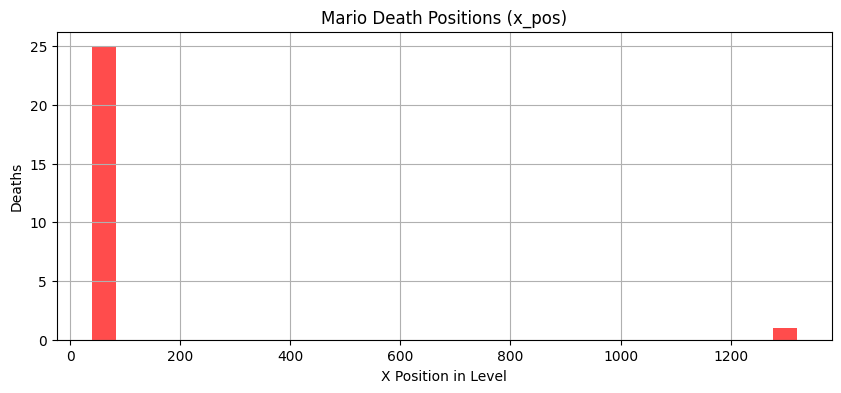

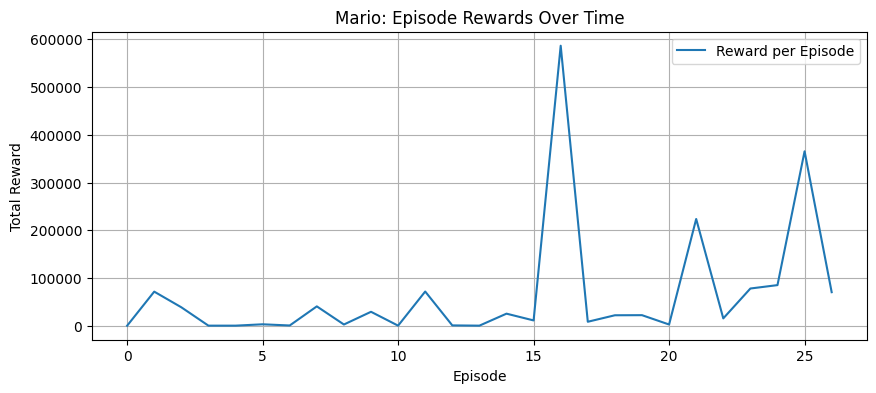

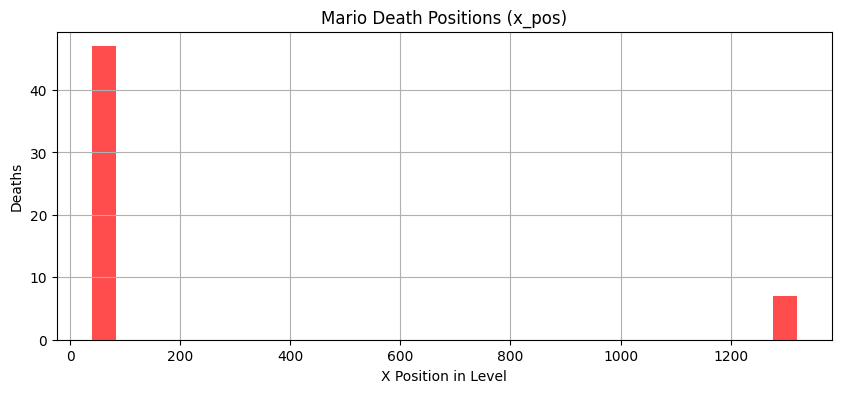

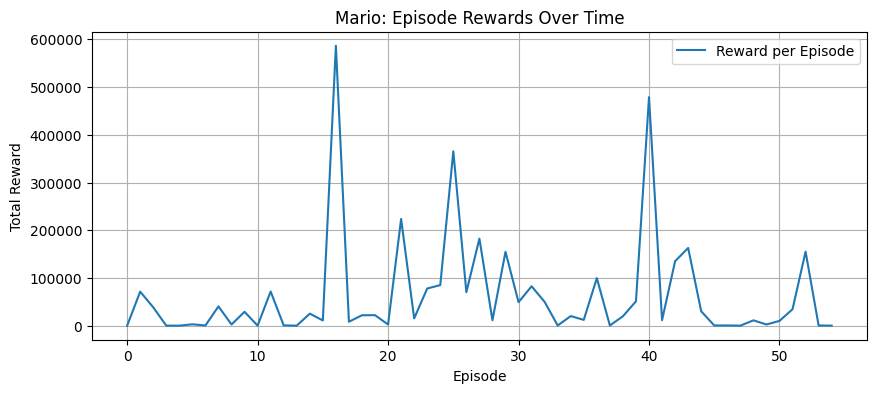

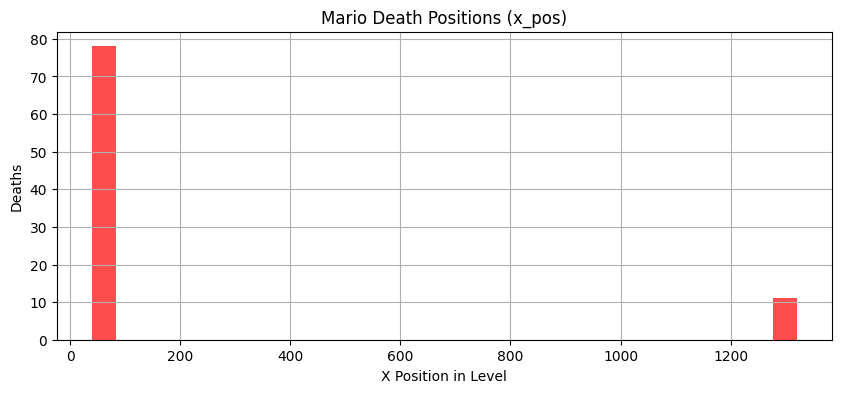

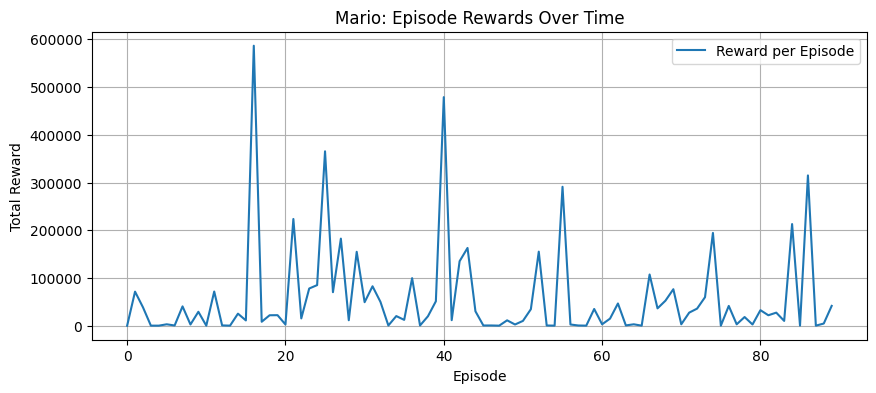

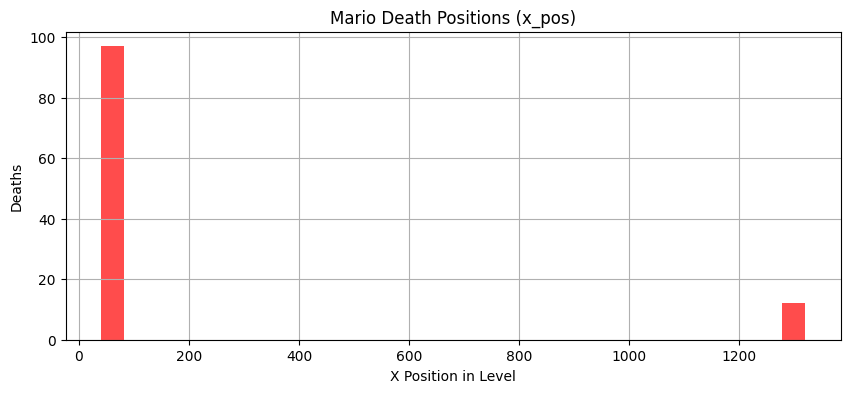

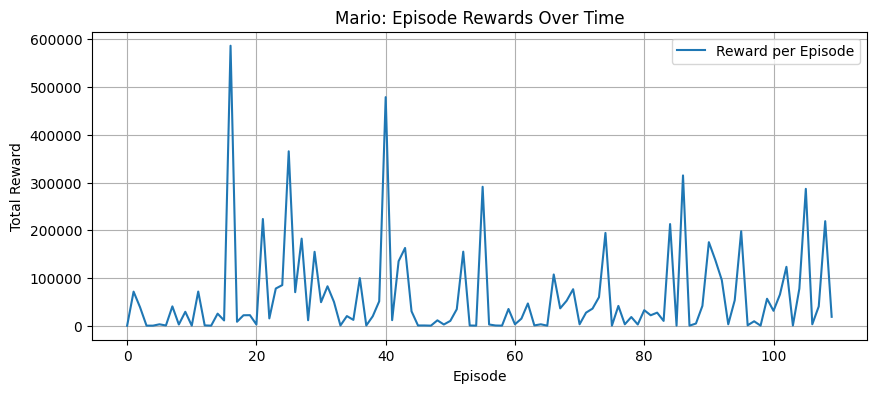

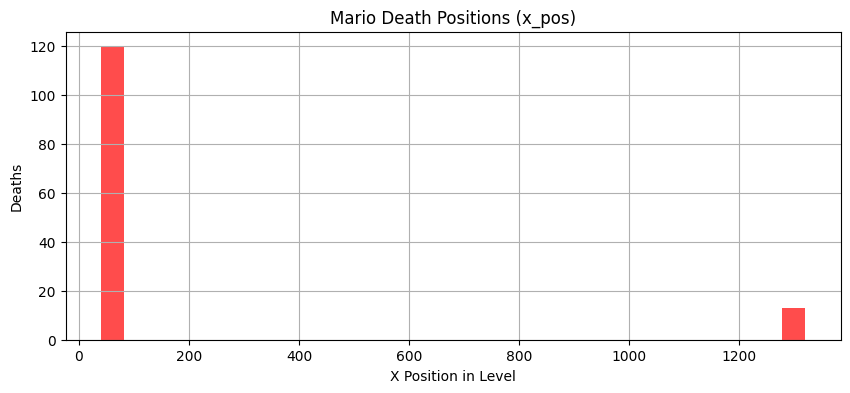

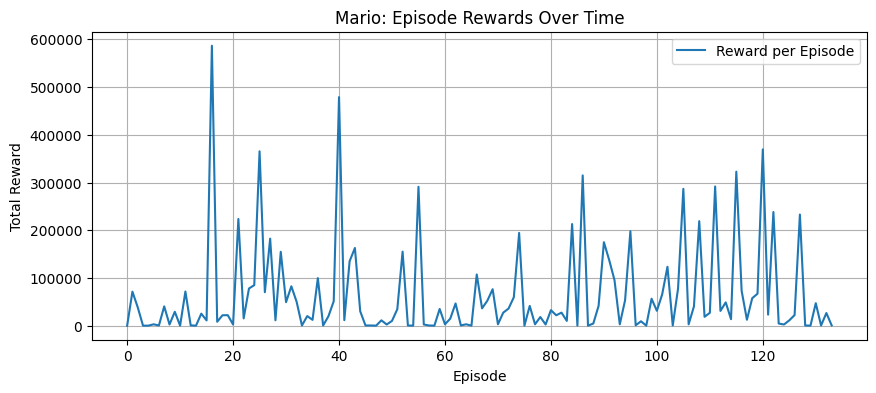

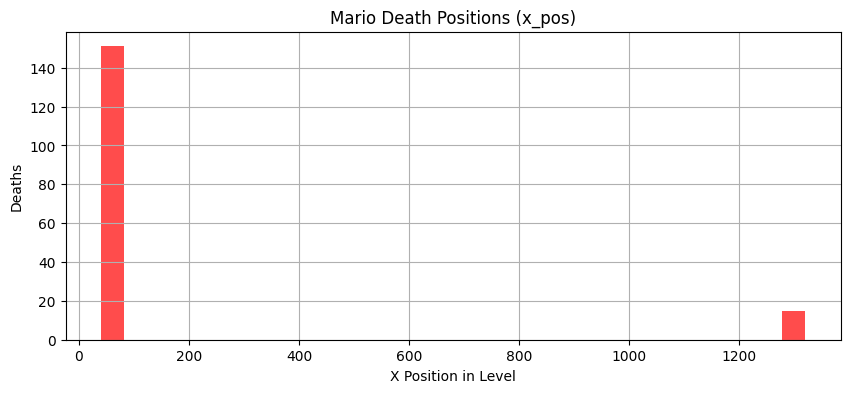

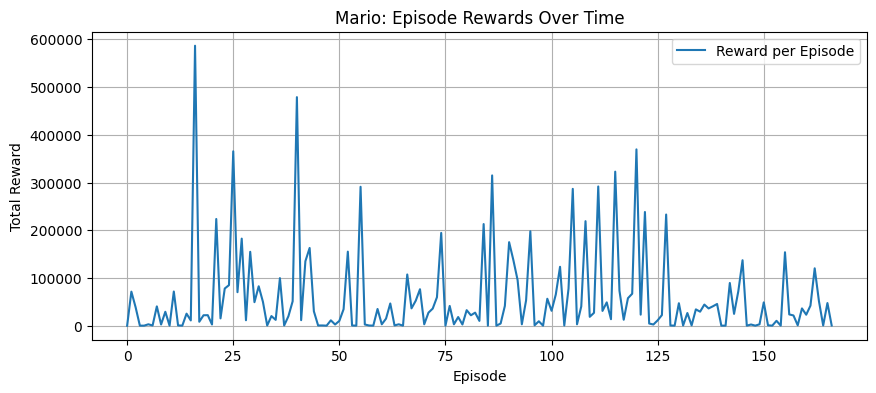

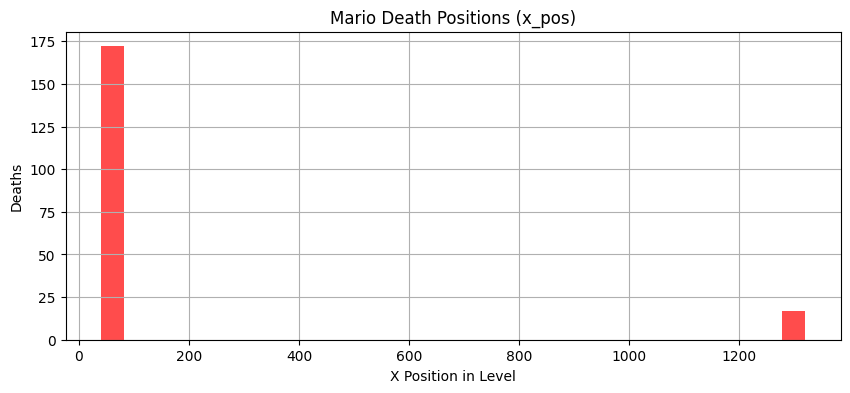

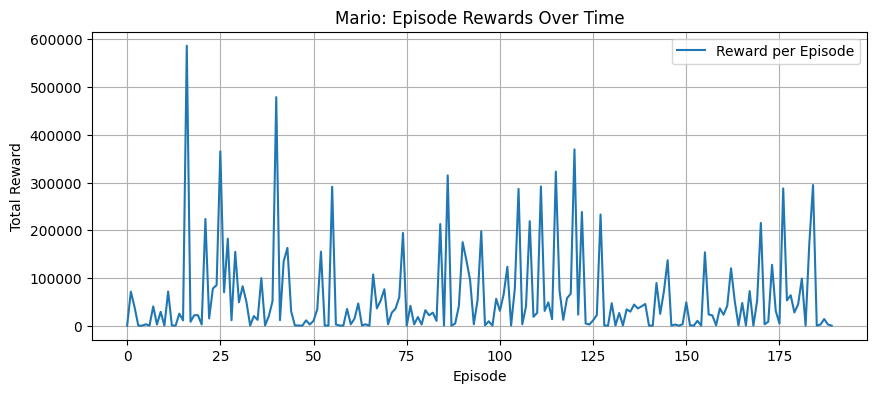

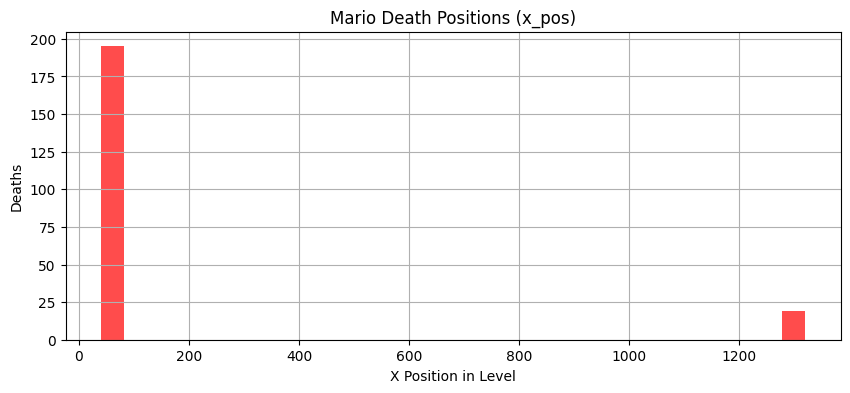

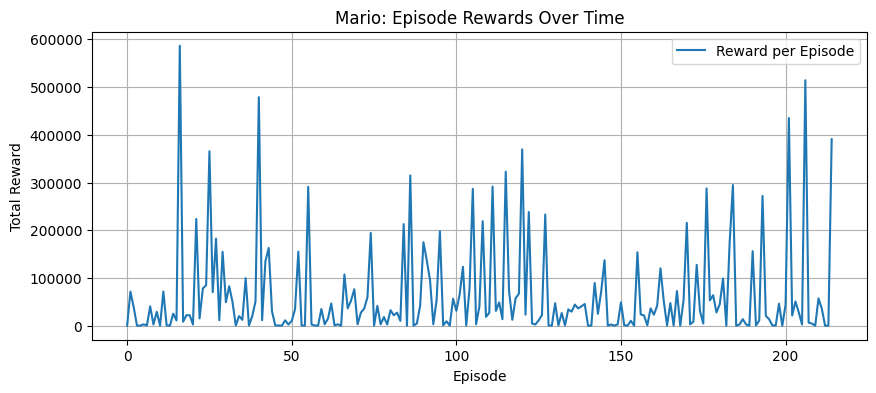

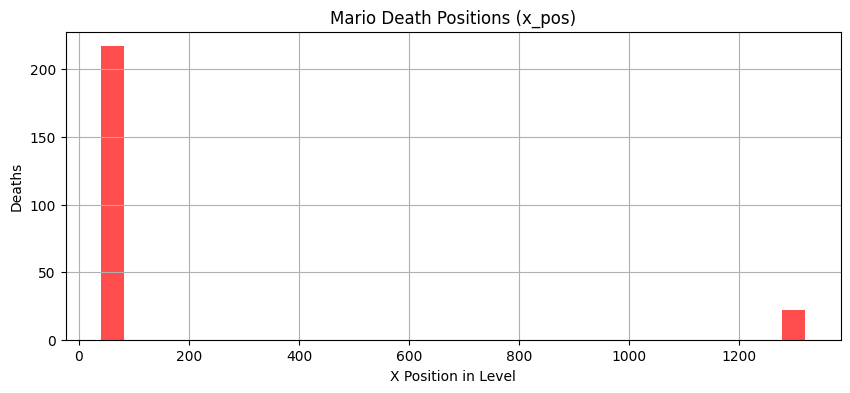

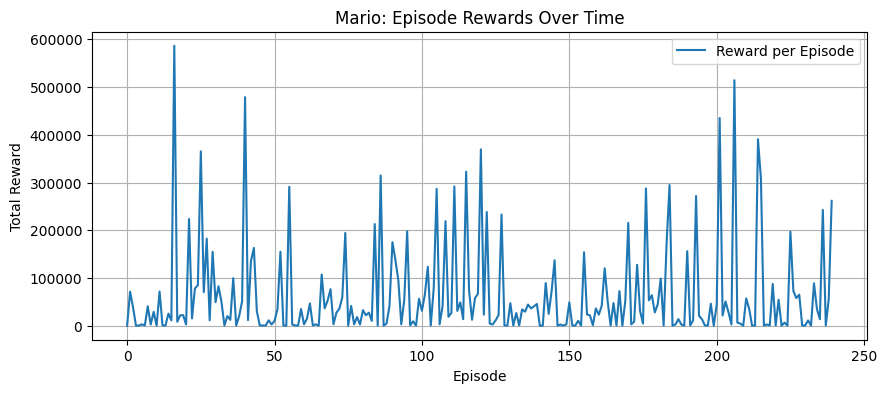

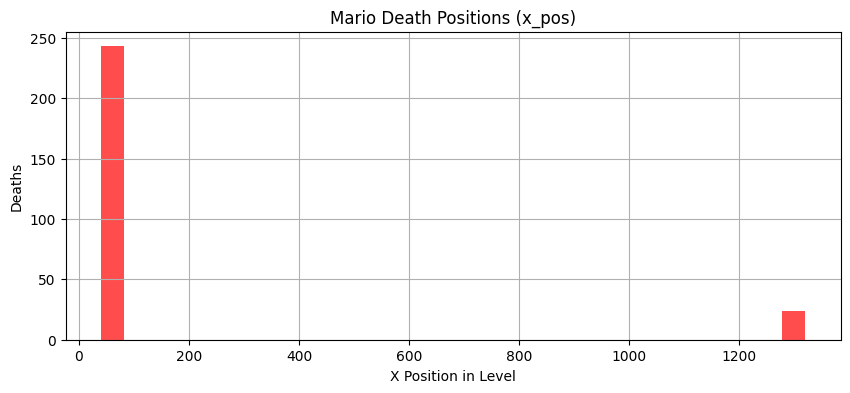

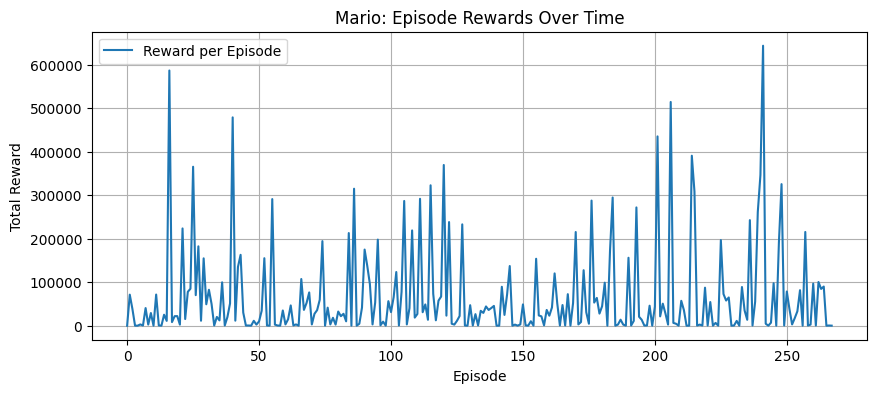

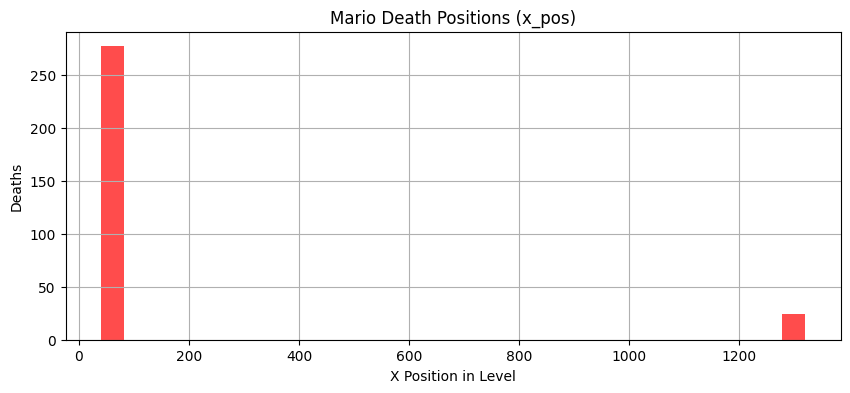

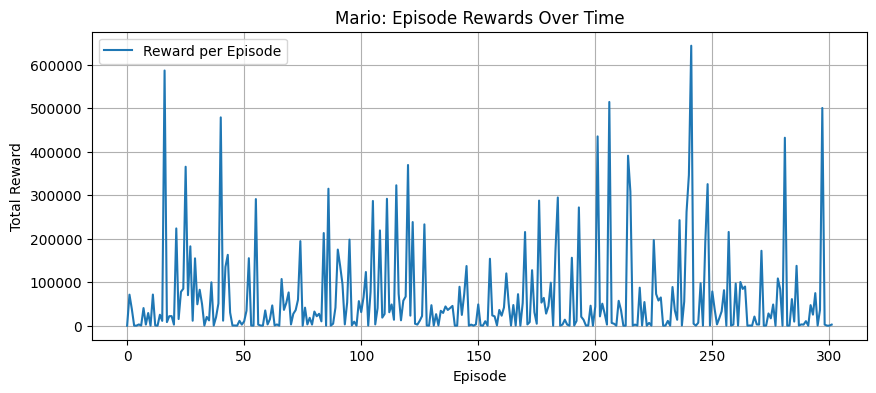

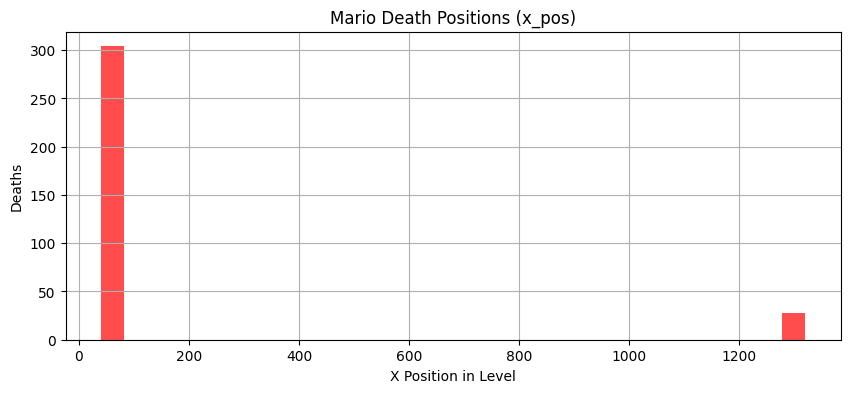

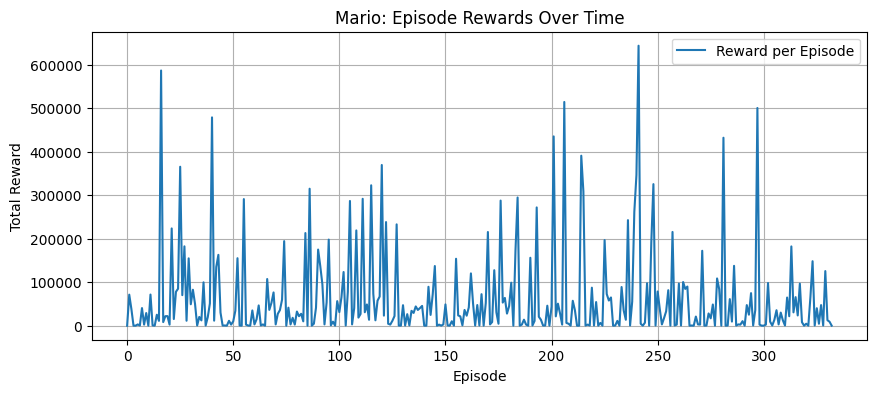

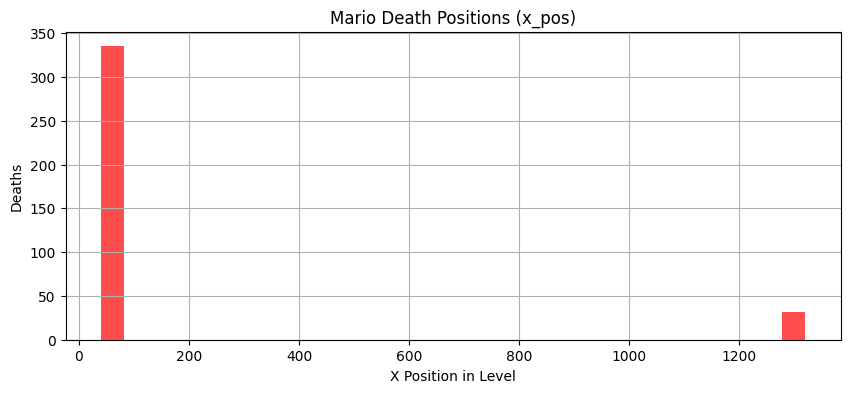

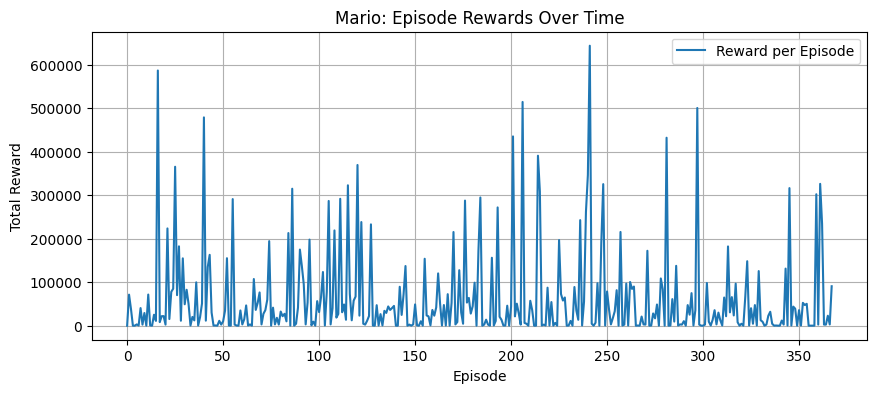

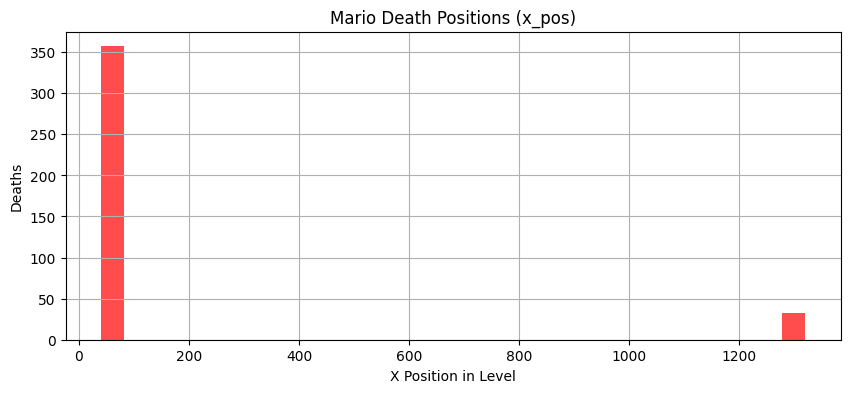

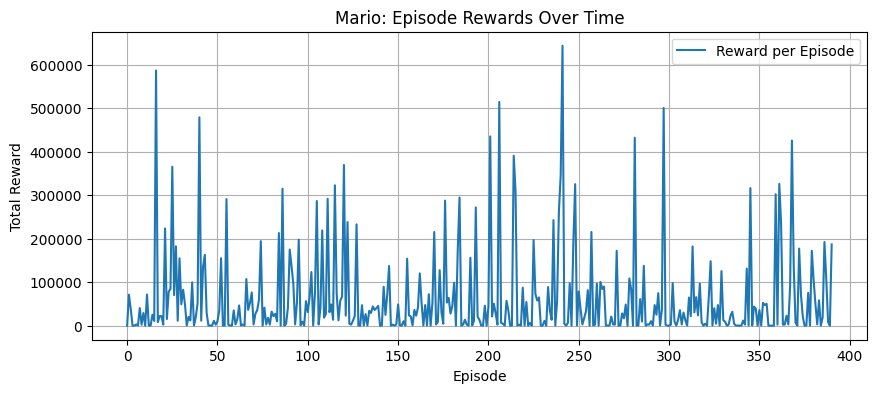

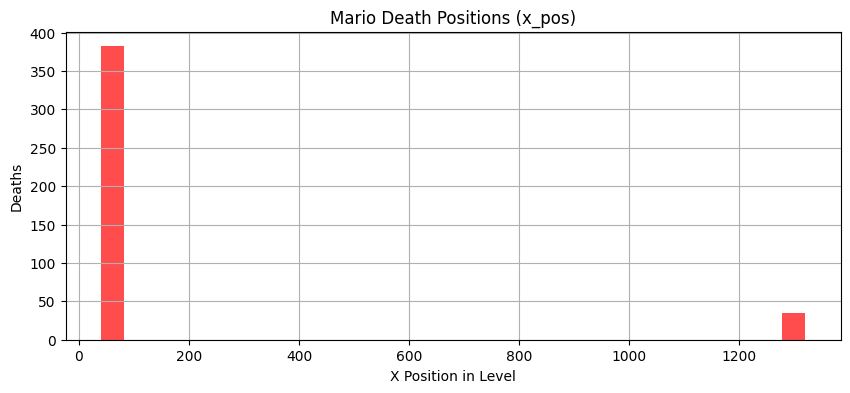

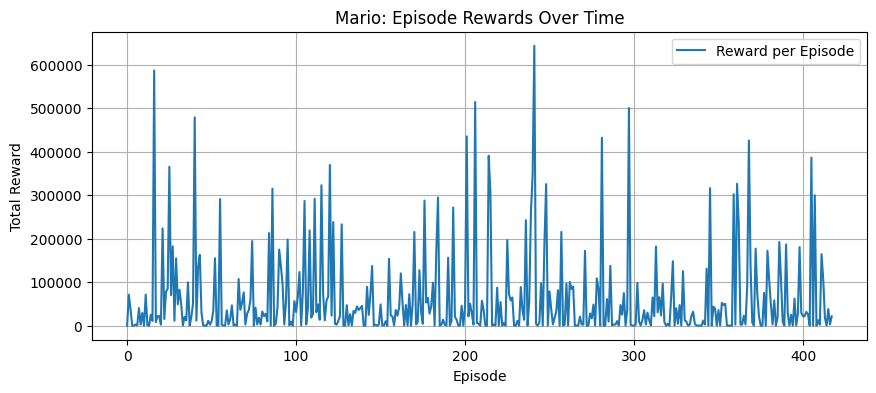

KeyboardInterrupt: 

In [14]:
# Initialize Environment with rendering
env = gym_super_mario_bros.make('SuperMarioBros-v0', 
                               apply_api_compatibility=True,
                               render_mode='human')
env = JoypadSpace(env, RIGHT_ONLY)
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = FrameStack(env, num_stack=4)


# Initialize Mario
mario = Mario(state_shape=(4, 84, 84), num_actions=env.action_space.n)

# To store last known checkpoint
checkpoint_state = None
checkpoint_info = None
current_level = None  # Tuple of (world, stage)

episode_reward = 0
episode_rewards = []


# Main game loop
done = True
state, info = env.reset(), {}
# Train the agent in the Mario world:
for step in range(100000):
    if done:
        #if checkpoint_state:
            #print(f"Loading checkpoint at world {checkpoint_info['world']}, stage {checkpoint_info['stage']}")
            #state = checkpoint_state
            #info = checkpoint_info
            #mario.last_x_pos = info.get('x_pos', 0)
        #else:
        state, info = env.reset(), {}
        mario.last_x_pos = info.get('x_pos', 0)
        episode_rewards.append(episode_reward)
        episode_reward = 0
            #current_level = (info.get('world'), info.get('stage'))

    #next_state, reward, done, info = env.step(env.action_space.sample())
    action = mario.act(state, info)
    #action = 4
    next_state, reward, done, info = env.step(action)
    state = next_state
    

    x_pos = info.get('x_pos', 0)
    v = x_pos - mario.last_x_pos
    reward += v
    mario.last_x_pos = x_pos

    c = -1 if v != 0 else 0
    reward += c

    # Reward for collecting coins and the overall score
    reward += info.get('coins', 0) * 2
    reward += info.get('score', 0) * 2

    # Level completion check
    if info.get('flag_get', False):
        reward += 100  # Bonus for clearing level
        current_level = (info.get('world'), info.get('stage'))
        #checkpoint_state = next_state  # Save checkpoint state
        #checkpoint_info = info
        #done = True  # End episode so agent starts from next level

    # Death check
    #if info.get('life', 1) < 1:
    if info.get('life') < 2:
        reward -= 100
        death_x = info.get('x_pos', 0)
        mario.death_positions.append(death_x)
        done = True  # Restart from checkpoint or beginning

    episode_reward += reward

    mario.cache(state, next_state, action, reward, done)
    mario.learn()


    # Histogram for error analysis
    if step % 5000 == 0:
        if len(mario.death_positions) > 0:
            plt.figure(figsize=(10, 4))
            plt.hist(mario.death_positions, bins=30, color='red', alpha=0.7)
            plt.title("Mario Death Positions (x_pos)")
            plt.xlabel("X Position in Level")
            plt.ylabel("Deaths")
            plt.grid(True)
            plt.show()

        if len(episode_rewards) >= 10:
            plt.figure(figsize=(10, 4))
            plt.plot(episode_rewards, label='Reward per Episode')
            plt.title("Mario: Episode Rewards Over Time")
            plt.xlabel("Episode")
            plt.ylabel("Total Reward")
            plt.grid(True)
            plt.legend()
            plt.show()

    
    #if step % 5000 == 0:
        #frame = state[-1]
        #plt.imshow(frame, cmap='gray')
        #plt.title("Last Frame")
        #plt.axvspan(50, 70, color='red', alpha=0.3, label='Pit/Enemy Detection Zone')
        #plt.axhspan(50, 80, color='blue', alpha=0.3)
        #plt.legend()
        #plt.show()


    env.render()

env.close()

## ERROR ANALYSIS:

A new death positions / episode rewards over time diagram is created for every 5,000th step the Mario agent takes during training (the diagrams above were a result of about 3 hours of training). As one can see from the Mario Death Positions histogram above, Mario always dies the most at positions 0-200. x_pos is a key in a dictionary that is returned from the step() method called from the gym-super-mario-bros library. This dictionary (info) contains various keys about information in the Mario world and is updated after each step Mario takes. 
It's important to note that I don't have a GPU- I have an Intel processor which is supposedly powerful, but not a GPU. With that said, I was never able to FULLY train my Mario AI- as that would take days or weeks of just having it run like this.
The histogram shows that the Mario AI did not advance very far in the game. The deaths occuring past the 1200 x position, I assume, is from Level 2. Sometimes my Mario AI beats the first level, but then he is unable to survive the second.
I believe if I was able to let this train for a much longer time, maybe the agent would eventually perfect the first level, and then be able to explore further and even complete the second. 
I tried hard coding 'check points'- such that if Mario runs out of his three lives in a level, he will start at THAT level. I thought this would help speed up the training- instead, it made the Mario ROM gameplay screen freeze and then break whenever Mario reached the flag. In the documentation for the gym-super-mario-bros library specified that the way it works is Mario has 3 lives- once he dies three times, he restarts from the beginning. I was unable to find a way to override this option.

The trends between all episode rewards over times after every 5,000 steps show no pattern. We would know my Mario agent is improving throughout his training if his rewards started low and got higher (short lines gradually turning into longer ones). Instead, we have what seems to be a chaotic, random assortment of lines that don't seem to correlate with one another. Mario's reward takes a heavy damage everytime he dies, so it's likely that every sudden drop in line is another death occurrence made by the Mario agent. If Mario is detected to have gotten the flag (at the end of the level, thus meaning he beat the level), the reward bonus is substantial (+100), and a higher score (enemy destruction count) as well as coins result in smaller bonuses to the overall reward. These stats show my agent's struggle to learn how to navigate in the Mario enviroment in a way that yields a consistent, high reward. In the later generated graphs, it's clear to see that more lines extend higher than the graphs generated earlier in training- so this shows that the agent is at least making progress to choose actions that yield higher rewards- very slowly, but surely- especially when you compare the first rewards over time results with the last.

## CONCLUSION:
While my Mario agent does not beat the entirety of SNES Mario Bros like I had intended it to, it at least has enough logic to traverse the Mario world with some bit of competence. By that, I mean my Mario agent is able to prioritize getting things like coins, points (by stomping on enemies), and the flag at the end of the level. If I had let this code run for a few days, or if I had a GPU, we would be analyzing different (and maybe better) results. I believe this means that my Mario agent was able to associate certain actions with higher rewards- which is good. 

I have a MacBook Pro with a decent Intel processor, but unfortunately, not a GPU. Because of this, the training process was slower than it could've been and as a result, the agent was never able to FULLY complete training- as this would require running this code for days. This is clearly shown in the chaotic results in the episode rewards over time graphs that were generated for every 5,000th step my Mario agent took. There is no pattern or gradual growth in my agent's overall reward score, if my agent was learning well, we wouldn't have tall lines suddenly drop to low ones. This ultimately shows that my Mario agent has a lot of trouble learning. I'd like to hope that if I had a GPU or let this run for 20+ hours, the lines shown in the rewards over time trends would be not as chaotic. Lines gradually becoming longer to show a higher reward- maybe with a sudden drop here or there for deaths encountered- but it would be nowhere near as chaotic as the ones shown above. 

I attempted to hardcode a check-point for each new level my Mario agent reaches as a way to speed up my agent's learning process. The way the gym-super-mario-bros environment library works is that Mario has three lives to beat the game, if he dies and still has remaining lives, he will respawn at the start of his current level. On the other hand, if Mario runs out of lives, he respawns at World 1 Level 1- alllllll the way at the beginning. My hard-coded checkpoint attempt didn't go well- I assume it interfered with internal mechanics of the gym-super-mario-bros enviroment because once my agent made it to the end of the first level with my hard-coded checkpoints, the entire game froze and then crashed. I was unable to find a way to override this option. 

Despite my failure, I learned a lot about reinforcement learning in complex games like Mario. Computational resources (like GPUs) are very, very important, and I understand now what people mean when they say 'ChatGPT is bad for the enviroment' (all of that computational power..). Also, I knew reward-shaping is important, but I never realized just HOW it is- without it, the agent seriously doesn't know anything. My agent wouldn't know that dying is bad and beating the levels is good without it. I've also never interfaced with actual game ROM before, and while the gym-super-mario-bros library did most of the heavy lifting, I did have to write three helper functions to help interface with it. Before starting this project, I didn't consider the complexity of the game and how that would go when inputting it into a neural network. The example I looked at on PyTorch reduced the game channels down to one, and when I saw this at first, I thought it was lame and I did everything I could in my power to not do this. Then, things got really hard and complicated, and I noticed that no tutorial of reinforcement learning in any gym enviroment game that went about doing this WITHOUT simplifying the enviroment in some way. So, I decided to reduce the enviroment down to grayscale- because most examples of interfacing with gym game ROM enviroments chose to do it in this way.

In the future, if I ever wind up with a more powerful computer, I could most definitely pick this project back up. While today I don't have the computational power to get a Mario AI to beat all of SNES Mario Bros, maybe tomorrow I'll stumble across a computer with triple the computational power that my current ones has. Unfortunately, this is not the end of my experiment, but only the beginning.

## WORKS CITED:
- @misc{gym-super-mario-bros,
  author = {Christian Kauten},
  howpublished = {GitHub},
  title = {{S}uper {M}ario {B}ros for {O}pen{AI} {G}ym},
  URL = {https://github.com/Kautenja/gym-super-mario-bros},
  year = {2018},
- https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html
- https://medium.com/@eodor02/building-an-intelligent-mario-bot-using-reinforcement-learning-and-python-1b9ac63ba4be
- https://python.plainenglish.io/build-an-ai-model-to-play-super-mario-7607b1ec1e17
- https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/
- https://community.ops.io/akilesh/reinforcement-learning-in-super-mario-bros-48a
-  https://github.com/adhiiisetiawan/atari-dqn/blob/main/dqn_atari.py
-  https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
-  https://medium.com/@liyinxuan0213/step-by-step-double-deep-q-networks-double-dqn-tutorial-from-atari-games-to-bioengineering-dec7e6373896
-  https://towardsdatascience.com/reinforcement-learning-explained-visually-part-5-deep-q-networks-step-by-step-5a5317197f4b/